In [1]:
import os 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb

def case_preprocessing():
    dataset = list()
    only_train_dataset = list()
    df = pd.DataFrame()
    train_df = pd.DataFrame()   # 새로운 Col 만들기 
    dir_path = 'C:\\Users\\gusrl\\opendrift\\drift_trajection'
    pastDir_path = 'C:\\Users\\gusrl\\opendrift\\drift_trajection\\Past_data'
    
    # hour, wind(바람의 x축,y축 방향 각각 제곱합의 루트), water(해류의 x축,y축 방향 각각 제곱합의 루트)
    for k in range(1,16):
        only_train_dataset.append(pd.read_csv(os.path.join(pastDir_path ,(str(k)+'.csv'))))
                                  
    # 2016 (case 7) (동해)
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_003.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_005.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_010.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_011.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_015.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_016.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_040.csv')))

    # 2018(case 12) (서해)
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_005.csv')))
    # dataset_list.append(pd.read_csv(os.path.join(dir_path,'2018_case_008.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_017.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_027.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_032.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_034.csv')))
    # dataset_list.append(pd.read_csv(os.path.join(dir_path,'2018_case_045.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_047.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_082.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_083.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_090.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_095.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_097.csv')))

    # 2019(case 4) (남해)
    dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_000.csv')))
#     dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_001.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_006.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_007.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_005.csv')))
    
    # 과거데이터 전처리 
    for i in range(len(only_train_dataset)):
        # 동해 서해 남해 
        if i <8:
            only_train_dataset[i]['E'] = 0
            only_train_dataset[i]['W'] = 0
            only_train_dataset[i]['S'] = 1
        else:
            only_train_dataset[i]['E'] = 0
            only_train_dataset[i]['W'] = 1
            only_train_dataset[i]['S'] = 0
        
        # 시간처리를 위해 time의 object type -> datetime64로 변경
        only_train_dataset[i]['time'] = pd.to_datetime(only_train_dataset[i]['time'],format = '%Y-%m-%d %H:%M', errors = 'raise')
        # hour열 생성
        only_train_dataset[i]['hour'] = only_train_dataset[i]['time'].dt.hour
        # wind 열 생성
        only_train_dataset[i]['wind'] = (only_train_dataset[i]['wind_x']**2 + only_train_dataset[i]['wind_y']**2)**(1/2)
        # water열 생성
        only_train_dataset[i]['water'] = (only_train_dataset[i]['water_velocity_x']**2 + only_train_dataset[i]['water_velocity_y']**2)**(1/2)
        # diff_lon열 생성
        only_train_dataset[i]['diff_lon'] = only_train_dataset[i]['obs_x1_lon'].diff() 
        only_train_dataset[i]['diff_lon'][0] = 0
        # diff_lat열 생성
        only_train_dataset[i]['diff_lat'] = only_train_dataset[i]['obs_x1_lat'].diff()
        only_train_dataset[i]['diff_lat'][0] = 0
        # 'diff_wind_x'열 생성
        only_train_dataset[i]['diff_wind_x'] = only_train_dataset[i]['wind_x'].diff() 
        only_train_dataset[i]['diff_wind_x'][0] = 0
        # 'diff_wind_y'열 생성
        only_train_dataset[i]['diff_wind_y'] = only_train_dataset[i]['wind_y'].diff()
        only_train_dataset[i]['diff_wind_y'][0] = 0
        # 'diff_wind_x'열 생성
        only_train_dataset[i]['diff_water_velocity_x'] = only_train_dataset[i]['water_velocity_x'].diff() 
        only_train_dataset[i]['diff_water_velocity_x'][0] = 0
        # 'diff_wind_y'열 생성
        only_train_dataset[i]['diff_water_velocity_y'] = only_train_dataset[i]['water_velocity_y'].diff() 
        only_train_dataset[i]['diff_water_velocity_y'][0] = 0
        # 초기 이동 고려 (원-핫 인코딩)
        only_train_dataset[i]['initial'] = 0
        only_train_dataset[i]['not_initial'] = 0
        for j in range(0,10):
            only_train_dataset[i]['not_initial'][j] = 0
            only_train_dataset[i]['initial'][j] = 1
        
        # model_x2_lon
        # diff_lon열 생성
        only_train_dataset[i]['diff_mod_lon'] = only_train_dataset[i]['model_x2_lon'].diff() 
        only_train_dataset[i]['diff_mod_lon'][0] = 0
        # diff_lat열 생성
        only_train_dataset[i]['diff_mod_lat'] = only_train_dataset[i]['model_x2_lat'].diff()
        only_train_dataset[i]['diff_mod_lat'][0] = 0
        
        only_train_dataset[i]['water_velocity_x_10'] = only_train_dataset[i]['water_velocity_x'] * 10
        only_train_dataset[i]['water_velocity_y_10'] = only_train_dataset[i]['water_velocity_y'] * 10
        
        # diff열 생성
        only_train_dataset[i]['diff'] = (only_train_dataset[i]['diff_lon']**2 + only_train_dataset[i]['diff_lat']**2)**(1/2)
        only_train_dataset[i]['diff'] = only_train_dataset[i]['diff']
        
        # Null 값 제외
        
        only_train_dataset[i] = only_train_dataset[i].dropna()
        only_train_dataset[i] = only_train_dataset[i].reset_index(drop = True)
        
        
        # 초기좌표 (해역 나누기)
        only_train_dataset[i]['start_lon'] = only_train_dataset[i]['obs_x1_lon'][0]
        only_train_dataset[i]['start_lat'] = only_train_dataset[i]['obs_x1_lat'][0]
        
        # Smoothing (wind_x_ma, wind_y_ma, water_velocity_x_ma, water_velocity_y_ma 인자 추가) 
        only_train_dataset[i]['wind_x_ma'] = 0
        only_train_dataset[i]['wind_y_ma'] = 0
        only_train_dataset[i]['water_velocity_x_ma'] = 0
        only_train_dataset[i]['water_velocity_y_ma'] = 0 
        for j in range(1,len(only_train_dataset[i])-1):
            only_train_dataset[i]['wind_x_ma'][j] = (only_train_dataset[i]['wind_x'][j-1] + only_train_dataset[i]['wind_x'][j] + only_train_dataset[i]['wind_x'][j+1])/3
            only_train_dataset[i]['wind_y_ma'][j] = (only_train_dataset[i]['wind_y'][j-1] + only_train_dataset[i]['wind_y'][j] + only_train_dataset[i]['wind_y'][j+1])/3
            only_train_dataset[i]['water_velocity_x_ma'][j] = (only_train_dataset[i]['water_velocity_x'][j-1] + only_train_dataset[i]['water_velocity_x'][j] + only_train_dataset[i]['water_velocity_x'][j+1])/3
            only_train_dataset[i]['water_velocity_y_ma'][j] = (only_train_dataset[i]['water_velocity_y'][j-1] + only_train_dataset[i]['water_velocity_y'][j] + only_train_dataset[i]['water_velocity_y'][j+1])/3    
        df = only_train_dataset[i]
        indices = df.query('wind_x < -90 or wind_y < -90 or water_velocity_x < -90 or water_velocity_y < -90').index
        df.drop(indices, inplace=True)
        df.reset_index(drop = True, inplace=True)
        only_train_dataset[i] = df 
        
     # 기상청 데이터 전처리 
    for i in range(len(dataset)):
        # 동해 서해 남해 
        if i <7:
            dataset[i]['E'] = 1
            dataset[i]['W'] = 0
            dataset[i]['S'] = 0
        elif i >= 7 and i<18:
            dataset[i]['E'] = 0
            dataset[i]['W'] = 1
            dataset[i]['S'] = 0
        else:
            dataset[i]['E'] = 0
            dataset[i]['W'] = 0
            dataset[i]['S'] = 1
        
        # 시간처리를 위해 time의 object type -> datetime64로 변경
        dataset[i]['time'] = pd.to_datetime(dataset[i]['time'],format = '%Y-%m-%d %H:%M', errors = 'raise')
        # hour열 생성
        dataset[i]['hour'] = dataset[i]['time'].dt.hour
        # wind 열 생성
        dataset[i]['wind'] = (dataset[i]['wind_x']**2 + dataset[i]['wind_y']**2)**(1/2)
        # water열 생성
        dataset[i]['water'] = (dataset[i]['water_velocity_x']**2 + dataset[i]['water_velocity_y']**2)**(1/2)
        # diff_lon열 생성
        dataset[i]['diff_lon'] = dataset[i]['obs_x1_lon'].diff() 
        dataset[i]['diff_lon'][0] = 0
        # diff_lat열 생성
        dataset[i]['diff_lat'] = dataset[i]['obs_x1_lat'].diff()
        dataset[i]['diff_lat'][0] = 0
        # 'diff_wind_x'열 생성
        dataset[i]['diff_wind_x'] = dataset[i]['wind_x'].diff() 
        dataset[i]['diff_wind_x'][0] = 0
        # 'diff_wind_y'열 생성
        dataset[i]['diff_wind_y'] = dataset[i]['wind_y'].diff()
        dataset[i]['diff_wind_y'][0] = 0
        # 'diff_wind_x'열 생성
        dataset[i]['diff_water_velocity_x'] = dataset[i]['water_velocity_x'].diff() 
        dataset[i]['diff_water_velocity_x'][0] = 0
        # 'diff_wind_y'열 생성
        dataset[i]['diff_water_velocity_y'] = dataset[i]['water_velocity_y'].diff() 
        dataset[i]['diff_water_velocity_y'][0] = 0
        
        # 초기 이동 고려 (원-핫 인코딩)
        dataset[i]['initial'] = 0
        dataset[i]['not_initial'] = 1
        for j in range(0,30):
            dataset[i]['not_initial'][j] = 0
            dataset[i]['initial'][j] = 1
        
        dataset[i]['diff_mod_lon'] = dataset[i]['model_x2_lon'].diff() 
        dataset[i]['diff_mod_lon'][0] = 0
        
        # diff_lat열 생성
        dataset[i]['diff_mod_lat'] = dataset[i]['model_x2_lat'].diff()
        dataset[i]['diff_mod_lat'][0] = 0
        
        # mod diff 
        dataset[i]['diff_mod'] = (dataset[i]['diff_mod_lon']**2 + dataset[i]['diff_mod_lat']**2)**(1/2)
        
        # diff열 생성
        dataset[i]['diff'] = (dataset[i]['diff_lon']**2 + dataset[i]['diff_lat']**2)**(1/2)
        
        # Null 값 제외
        dataset[i] = dataset[i].dropna()
        dataset[i] = dataset[i].reset_index(drop = True)
        
        # 초기좌표 (해역 나누기)
        dataset[i]['start_lon'] = dataset[i]['obs_x1_lon'][0]
        dataset[i]['start_lat'] = dataset[i]['obs_x1_lat'][0]
        
        # Smoothing (wind_x_ma, wind_y_ma, water_velocity_x_ma, water_velocity_y_ma 인자 추가) 
        dataset[i]['wind_x_ma'] = 0
        dataset[i]['wind_y_ma'] = 0
        dataset[i]['water_velocity_x_ma'] = 0
        dataset[i]['water_velocity_y_ma'] = 0 
        for j in range(1,len(dataset[i])-1):
            dataset[i]['wind_x_ma'][j] = (dataset[i]['wind_x'][j-1] + dataset[i]['wind_x'][j] + dataset[i]['wind_x'][j+1])/3
            dataset[i]['wind_y_ma'][j] = (dataset[i]['wind_y'][j-1] + dataset[i]['wind_y'][j] + dataset[i]['wind_y'][j+1])/3
            dataset[i]['water_velocity_x_ma'][j] = (dataset[i]['water_velocity_x'][j-1] + dataset[i]['water_velocity_x'][j] + dataset[i]['water_velocity_x'][j+1])/3
            dataset[i]['water_velocity_y_ma'][j] = (dataset[i]['water_velocity_y'][j-1] + dataset[i]['water_velocity_y'][j] + dataset[i]['water_velocity_y'][j+1])/3
        
        # 삭제 전 원본 df
        df = pd.concat([df,dataset[i]],ignore_index = True)
        # 불필요열 삭제 
        pre_df = dataset[i].drop(columns = ['time','obs_x1_lon','obs_x1_lat','model_x2_lon','model_x2_lat'])  
        train_df = pd.concat([train_df, pre_df[1:-1]],ignore_index = True)
        
    df = df.reset_index(drop = True)
    train_df = train_df.reset_index(drop = True)
    return dataset, df, train_df, only_train_dataset

def drift_mae(y, predict_y):
    mae = mean_absolute_error(y, predict_y)
    return mae


def n2_mae(y, predict_y):
    n = y.shape[0]
    error_sum = 0
    
    for i in range(n):
        error_sum += abs((y[i][0] - predict_y[i][0])) + abs(( y[i][1] - predict_y[i][1]))
    
    mae = error_sum/(2*n)   
    
    return mae


def paper_mae(y, predict_y): # 논문  
    n = y.shape[0]
    error_sum = 0
    
    for i in range(n):
        error_sum += abs(y[i][0] - predict_y[i][0]) + abs(y[i][1] - predict_y[i][1])
    
    mae = error_sum/n    
    return mae

def NCLS_score(y, predict_y): # 1시간 
        # dl_i 구하기 
        dl_list, dl_sum, o_sum = list(), list(), 0
        n = y.shape[0]
        for i in range(1, n):
            # 위도 1도는 111.321, 경도 1도는 87.74km, 단위 km
            d_lon = y[i][0] - y[i-1][0]  
            d_lat = y[i][1] - y[i-1][1]
            # 거리 구하기
            point_distance = np.sqrt(np.power(d_lon,2) + np.power(d_lat,2))
            dl_list.append(point_distance)
            
        for i in range(len(dl_list)):
            temp = 0
            for j in range(i+1):
                temp += dl_list[j]
            dl_sum.append(temp)

        for i in range(len(dl_sum)):
            o_sum += dl_sum[i]
        
        # 예측모델의 d_i 구하기
        d_list = list()
        for i in range(1,n):
            # 위도 1도는 111.321 # 경도 1도는 55.802km
            d_lon = y[i][0] - predict_y[i][0]  
            d_lat = y[i][1] - predict_y[i][1]
            # 거리 구하기
            point_distance = np.sqrt(np.power(d_lon,2) + np.power(d_lat,2))
            d_list.append(point_distance)

        # s 구하기
        d_sum, s, ss_score = 0, 0, 0

        for i in range(len(d_list)):
            d_sum += d_list[i]

        s = d_sum/o_sum
        
        if s > 1:
                ss_score = 0
        else:
            ss_score = 1-s
        
        return ss_score

def drift_trajection_show(index, y_pred): 
    %matplotlib inline

    # 실제 위치
    lon = dataset[index]['obs_x1_lon']
    lon = np.array(lon)
    lat = dataset[index]['obs_x1_lat']
    lat = np.array(lat)
    
    # baseline
    baseline_lon = dataset[index]['model_x2_lon']
    baseline_lon = np.array(baseline_lon)
    baseline_lat = dataset[index]['model_x2_lat']
    baseline_lat = np.array(baseline_lat)

    # 예측값 
    first_lon = lon[0]
    first_lat = lat[0]
    lon_pred = np.zeros((y_pred.shape[0]+1,))
    lat_pred = np.zeros((y_pred.shape[0]+1,))
    lon_pred[0] = first_lon 
    lat_pred[0] = first_lat
    
    for i in range(1, lon_pred.shape[0]):
        lon_pred[i] = lon_pred[i-1] + y_pred[i-1][0]
        lat_pred[i] = lat_pred[i-1] + y_pred[i-1][1]
        
    return lon, lat, baseline_lon, baseline_lat, lon_pred, lat_pred

def std_scaler(train_X, test_X):
    from sklearn.preprocessing import StandardScaler
    std = StandardScaler()
    std.fit(train_X)
    train_X_scaled = std.transform(train_X)
    test_X_scaled = std.transform(test_X)
    return train_X_scaled, test_X_scaled

def MinMax_scaler(train_X, test_X):
    from sklearn.preprocessing import MinMaxScaler
    mms = MinMaxScaler()
    mms.fit(train_X)
    train_X_scaled = mms.transform(train_X)
    test_X_scaled = mms.transform(test_X)
    return train_X_scaled, test_X_scaled
    
def roburst_scaler(train_X, test_X):
    from sklearn.preprocessing import RobustScaler
    rbs = RobustScaler()
    train_X_scaled = rbs.fit_transform(train_X)
    test_X_scaled = rbs.transform(test_X)
    return train_X_scaled, test_X_scaled


def maxAbsScaler(train_X, test_X):

    from sklearn.preprocessing import MaxAbsScaler
    maxAbsScaler = MaxAbsScaler()
    train_X_scaled = maxAbsScaler.fit_transform(train_X)
    test_X_scaled = maxAbsScaler.transform(test_X)
    return train_X_scaled, test_X_scaled

In [2]:
dataset, concat_df, train_df, only_train_dataset = case_preprocessing()

C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\3953088137.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]['diff_lon'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\3953088137.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]['diff_lat'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\3953088137.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_data

C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\3953088137.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]['diff_water_velocity_y'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\3953088137.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]['not_initial'][j] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\3953088137.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\3953088137.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['diff_lon'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\3953088137.py:167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['diff_lat'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\3953088137.py:170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['diff_wind_x'][0] = 0
C

C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\3953088137.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['diff_lon'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\3953088137.py:167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['diff_lat'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\3953088137.py:170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['diff_wind_x'][0] = 0
C

In [21]:
from tensorflow.keras.models import Model
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
          Dense(units = latent_dim, input_dim = 6, activation='relu')
        ])
        self.decoder = tf.keras.Sequential([
          Dense(6,activation='tanh')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Epoch 1/100
93/93 [==============================] - 1s 925us/step - loss: 8.2805
Epoch 2/100
93/93 [==============================] - 0s 919us/step - loss: 7.5925
Epoch 3/100
93/93 [==============================] - 0s 919us/step - loss: 6.8857
Epoch 4/100
93/93 [==============================] - 0s 940us/step - loss: 6.6033
Epoch 5/100
93/93 [==============================] - 0s 919us/step - loss: 6.4439
Epoch 6/100
93/93 [==============================] - 0s 897us/step - loss: 6.3201
Epoch 7/100
93/93 [==============================] - 0s 886us/step - loss: 6.2107
Epoch 8/100
93/93 [==============================] - 0s 913us/step - loss: 6.1301
Epoch 9/100
93/93 [==============================] - 0s 897us/step - loss: 6.0628
Epoch 10/100
93/93 [==============================] - 0s 919us/step - loss: 6.0013
Epoch 11/100
93/93 [==============================] - 0s 951us/step - loss: 5.9438
Epoch 12/100
93/93 [==============================] - 0s 886us/step - loss: 5.8691
Epoch 13/100


93/93 [==============================] - 0s 995us/step - loss: 5.6819


C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

------------------------ Model  1 ------------------------
baseline 0  MAE :  0.2753821503953004
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.24923079470507248
Epoch 1/100


C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['model_diff_lon'] = test_case_df['model_x2_lon'].diff()
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['model_diff_lon'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

93/93 [==============================] - 0s 940us/step - loss: 8.1411
Epoch 2/100
93/93 [==============================] - 0s 951us/step - loss: 7.5096
Epoch 3/100
93/93 [==============================] - 0s 977us/step - loss: 6.8253
Epoch 4/100
93/93 [==============================] - 0s 1ms/step - loss: 6.3564
Epoch 5/100
93/93 [==============================] - 0s 1ms/step - loss: 6.1051
Epoch 6/100
93/93 [==============================] - 0s 1ms/step - loss: 5.9812
Epoch 7/100
93/93 [==============================] - 0s 1ms/step - loss: 5.9126
Epoch 8/100
93/93 [==============================] - 0s 1ms/step - loss: 5.8767
Epoch 9/100
93/93 [==============================] - 0s 1ms/step - loss: 5.8555
Epoch 10/100
93/93 [==============================] - 0s 1ms/step - loss: 5.8420
Epoch 11/100
93/93 [==============================] - 0s 984us/step - loss: 5.8333
Epoch 12/100
93/93 [==============================] - 0s 984us/step - loss: 5.8272
Epoch 13/100
93/93 [===================

C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

------------------------ Model  1 ------------------------
baseline 0  MAE :  0.2753821503953004
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.24923079470507248
------------------------ Model  2 ------------------------
baseline 1  MAE :  0.3619249377715051
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.06154856710130818
Epoch 1/100


C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

93/93 [==============================] - 0s 946us/step - loss: 8.5654
Epoch 2/100
93/93 [==============================] - 0s 973us/step - loss: 8.0626
Epoch 3/100
93/93 [==============================] - 0s 1ms/step - loss: 7.8009
Epoch 4/100
93/93 [==============================] - 0s 995us/step - loss: 7.3911
Epoch 5/100
93/93 [==============================] - 0s 1ms/step - loss: 6.5616
Epoch 6/100
93/93 [==============================] - 0s 1ms/step - loss: 6.1428
Epoch 7/100
93/93 [==============================] - 0s 1ms/step - loss: 5.9955
Epoch 8/100
93/93 [==============================] - 0s 1ms/step - loss: 5.8864
Epoch 9/100
93/93 [==============================] - 0s 1ms/step - loss: 5.8207
Epoch 10/100
93/93 [==============================] - 0s 1ms/step - loss: 5.7799
Epoch 11/100
93/93 [==============================] - 0s 1ms/step - loss: 5.7521
Epoch 12/100
93/93 [==============================] - 0s 1ms/step - loss: 5.7338
Epoch 13/100
93/93 [=======================

C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

------------------------ Model  1 ------------------------
baseline 0  MAE :  0.2753821503953004
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.24923079470507248
------------------------ Model  2 ------------------------
baseline 1  MAE :  0.3619249377715051
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.06154856710130818
------------------------ Model  3 ------------------------
baseline 2  MAE :  0.29447843973347376
Model 2  MAE :  0.35204785416666873
baseline 2  NCLS :  0.303683671695795
Model 2  NCLS :  0.4068515107014965
Epoch 1/100
93/93 [==============================] - 0s 1ms/step - loss: 9.1814
Epoch 2/100
93/93 [==============================] - 0s 1ms/step - loss: 8.1470
Epoch 3/100
93/93 [==============================] - 0s 1ms/step - loss: 7.3452
Epoch 4/100
93/93 [==============================] - 0s 1ms/step - loss: 7.0694
Epoch 5/100
93/93 [==============================] - 0s 1ms/step - loss: 

93/93 [==============================] - 0s 1ms/step - loss: 5.7738
Epoch 95/100
93/93 [==============================] - 0s 1ms/step - loss: 5.7735
Epoch 96/100
93/93 [==============================] - 0s 1ms/step - loss: 5.7732
Epoch 97/100
93/93 [==============================] - 0s 1ms/step - loss: 5.7728
Epoch 98/100
93/93 [==============================] - 0s 1ms/step - loss: 5.7725
Epoch 99/100
93/93 [==============================] - 0s 1ms/step - loss: 5.7720
Epoch 100/100
93/93 [==============================] - 0s 1ms/step - loss: 5.7717


C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:114: SettingW

------------------------ Model  1 ------------------------
baseline 0  MAE :  0.2753821503953004
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.24923079470507248
------------------------ Model  2 ------------------------
baseline 1  MAE :  0.3619249377715051
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.06154856710130818
------------------------ Model  3 ------------------------
baseline 2  MAE :  0.29447843973347376
Model 2  MAE :  0.35204785416666873
baseline 2  NCLS :  0.303683671695795
Model 2  NCLS :  0.4068515107014965
------------------------ Model  4 ------------------------
baseline 3  MAE :  0.13370674660698822
Model 3  MAE :  0.23924403521126655
baseline 3  NCLS :  0
Model 3  NCLS :  0.35528117385149005
Epoch 1/100
93/93 [==============================] - 0s 930us/step - loss: 8.3659
Epoch 2/100
93/93 [==============================] - 0s 964us/step - loss: 7.6407
Epoch 3/100
93/93 [=================

93/93 [==============================] - 0s 1ms/step - loss: 5.6382
Epoch 93/100
93/93 [==============================] - 0s 1ms/step - loss: 5.6381
Epoch 94/100
93/93 [==============================] - 0s 1ms/step - loss: 5.6380
Epoch 95/100
93/93 [==============================] - 0s 1ms/step - loss: 5.6379
Epoch 96/100
93/93 [==============================] - 0s 1ms/step - loss: 5.6378
Epoch 97/100
93/93 [==============================] - 0s 1ms/step - loss: 5.6377
Epoch 98/100
93/93 [==============================] - 0s 1ms/step - loss: 5.6376
Epoch 99/100
93/93 [==============================] - 0s 1ms/step - loss: 5.6374
Epoch 100/100
93/93 [==============================] - 0s 1ms/step - loss: 5.6373


C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

------------------------ Model  1 ------------------------
baseline 0  MAE :  0.2753821503953004
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.24923079470507248
------------------------ Model  2 ------------------------
baseline 1  MAE :  0.3619249377715051
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.06154856710130818
------------------------ Model  3 ------------------------
baseline 2  MAE :  0.29447843973347376
Model 2  MAE :  0.35204785416666873
baseline 2  NCLS :  0.303683671695795
Model 2  NCLS :  0.4068515107014965
------------------------ Model  4 ------------------------
baseline 3  MAE :  0.13370674660698822
Model 3  MAE :  0.23924403521126655
baseline 3  NCLS :  0
Model 3  NCLS :  0.35528117385149005
------------------------ Model  5 ------------------------
baseline 4  MAE :  0.17848518031096405
Model 4  MAE :  0.1435844929577459
baseline 4  NCLS :  0.6956370589263559
Model 4  NCLS :  0.616324432

93/93 [==============================] - 0s 1ms/step - loss: 5.6039
Epoch 90/100
93/93 [==============================] - 0s 1ms/step - loss: 5.6038
Epoch 91/100
93/93 [==============================] - 0s 1ms/step - loss: 5.6035
Epoch 92/100
93/93 [==============================] - 0s 1ms/step - loss: 5.6034
Epoch 93/100
93/93 [==============================] - 0s 1ms/step - loss: 5.6033
Epoch 94/100
93/93 [==============================] - 0s 1ms/step - loss: 5.6033
Epoch 95/100
93/93 [==============================] - 0s 1ms/step - loss: 5.6030
Epoch 96/100
93/93 [==============================] - 0s 1ms/step - loss: 5.6029
Epoch 97/100
93/93 [==============================] - 0s 1ms/step - loss: 5.6027
Epoch 98/100
93/93 [==============================] - 0s 1ms/step - loss: 5.6025
Epoch 99/100
93/93 [==============================] - 0s 1ms/step - loss: 5.6021
Epoch 100/100
93/93 [==============================] - 0s 1ms/step - loss: 5.6019


C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

------------------------ Model  1 ------------------------
baseline 0  MAE :  0.2753821503953004
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.24923079470507248
------------------------ Model  2 ------------------------
baseline 1  MAE :  0.3619249377715051
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.06154856710130818
------------------------ Model  3 ------------------------
baseline 2  MAE :  0.29447843973347376
Model 2  MAE :  0.35204785416666873
baseline 2  NCLS :  0.303683671695795
Model 2  NCLS :  0.4068515107014965
------------------------ Model  4 ------------------------
baseline 3  MAE :  0.13370674660698822
Model 3  MAE :  0.23924403521126655
baseline 3  NCLS :  0
Model 3  NCLS :  0.35528117385149005
------------------------ Model  5 ------------------------
baseline 4  MAE :  0.17848518031096405
Model 4  MAE :  0.1435844929577459
baseline 4  NCLS :  0.6956370589263559
Model 4  NCLS :  0.616324432

C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

93/93 [==============================] - 0s 1ms/step - loss: 7.7005
Epoch 2/100
93/93 [==============================] - 0s 1ms/step - loss: 6.9640
Epoch 3/100
93/93 [==============================] - 0s 1ms/step - loss: 6.6543
Epoch 4/100
93/93 [==============================] - 0s 1ms/step - loss: 6.4352
Epoch 5/100
93/93 [==============================] - 0s 1ms/step - loss: 6.2558
Epoch 6/100
93/93 [==============================] - 0s 1ms/step - loss: 6.1471
Epoch 7/100
93/93 [==============================] - 0s 1ms/step - loss: 6.0921
Epoch 8/100
93/93 [==============================] - 0s 1ms/step - loss: 6.0527
Epoch 9/100
93/93 [==============================] - 0s 1ms/step - loss: 6.0197
Epoch 10/100
93/93 [==============================] - 0s 1ms/step - loss: 5.9912
Epoch 11/100
93/93 [==============================] - 0s 1ms/step - loss: 5.9648
Epoch 12/100
93/93 [==============================] - 0s 1ms/step - loss: 5.9386
Epoch 13/100
93/93 [=============================

C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:114: SettingW

------------------------ Model  1 ------------------------
baseline 0  MAE :  0.2753821503953004
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.24923079470507248
------------------------ Model  2 ------------------------
baseline 1  MAE :  0.3619249377715051
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.06154856710130818
------------------------ Model  3 ------------------------
baseline 2  MAE :  0.29447843973347376
Model 2  MAE :  0.35204785416666873
baseline 2  NCLS :  0.303683671695795
Model 2  NCLS :  0.4068515107014965
------------------------ Model  4 ------------------------
baseline 3  MAE :  0.13370674660698822
Model 3  MAE :  0.23924403521126655
baseline 3  NCLS :  0
Model 3  NCLS :  0.35528117385149005
------------------------ Model  5 ------------------------
baseline 4  MAE :  0.17848518031096405
Model 4  MAE :  0.1435844929577459
baseline 4  NCLS :  0.6956370589263559
Model 4  NCLS :  0.616324432

93/93 [==============================] - 0s 1ms/step - loss: 5.4679
Epoch 85/100
93/93 [==============================] - 0s 1ms/step - loss: 5.4680
Epoch 86/100
93/93 [==============================] - 0s 1ms/step - loss: 5.4679
Epoch 87/100
93/93 [==============================] - 0s 1ms/step - loss: 5.4679
Epoch 88/100
93/93 [==============================] - 0s 1ms/step - loss: 5.4681
Epoch 89/100
93/93 [==============================] - 0s 1ms/step - loss: 5.4680
Epoch 90/100
93/93 [==============================] - 0s 1ms/step - loss: 5.4678
Epoch 91/100
93/93 [==============================] - 0s 1ms/step - loss: 5.4678
Epoch 92/100
93/93 [==============================] - 0s 1ms/step - loss: 5.4678
Epoch 93/100
93/93 [==============================] - 0s 1ms/step - loss: 5.4678
Epoch 94/100
93/93 [==============================] - 0s 1ms/step - loss: 5.4680
Epoch 95/100
93/93 [==============================] - 0s 1ms/step - loss: 5.4678
Epoch 96/100
93/93 [=====================

C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

------------------------ Model  1 ------------------------
baseline 0  MAE :  0.2753821503953004
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.24923079470507248
------------------------ Model  2 ------------------------
baseline 1  MAE :  0.3619249377715051
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.06154856710130818
------------------------ Model  3 ------------------------
baseline 2  MAE :  0.29447843973347376
Model 2  MAE :  0.35204785416666873
baseline 2  NCLS :  0.303683671695795
Model 2  NCLS :  0.4068515107014965
------------------------ Model  4 ------------------------
baseline 3  MAE :  0.13370674660698822
Model 3  MAE :  0.23924403521126655
baseline 3  NCLS :  0
Model 3  NCLS :  0.35528117385149005
------------------------ Model  5 ------------------------
baseline 4  MAE :  0.17848518031096405
Model 4  MAE :  0.1435844929577459
baseline 4  NCLS :  0.6956370589263559
Model 4  NCLS :  0.616324432

C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:114: SettingW

93/93 [==============================] - 0s 951us/step - loss: 8.6543
Epoch 2/100
93/93 [==============================] - 0s 1ms/step - loss: 7.5724
Epoch 3/100
93/93 [==============================] - 0s 1ms/step - loss: 6.8096
Epoch 4/100
93/93 [==============================] - 0s 1ms/step - loss: 6.5450
Epoch 5/100
93/93 [==============================] - 0s 1ms/step - loss: 6.3958
Epoch 6/100
93/93 [==============================] - 0s 1ms/step - loss: 6.2839
Epoch 7/100
93/93 [==============================] - 0s 1ms/step - loss: 6.1995
Epoch 8/100
93/93 [==============================] - 0s 1ms/step - loss: 6.1359
Epoch 9/100
93/93 [==============================] - 0s 1ms/step - loss: 6.0854
Epoch 10/100
93/93 [==============================] - 0s 1ms/step - loss: 6.0434
Epoch 11/100
93/93 [==============================] - 0s 1ms/step - loss: 6.0073
Epoch 12/100
93/93 [==============================] - 0s 1ms/step - loss: 5.9759
Epoch 13/100
93/93 [===========================

C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

------------------------ Model  1 ------------------------
baseline 0  MAE :  0.2753821503953004
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.24923079470507248
------------------------ Model  2 ------------------------
baseline 1  MAE :  0.3619249377715051
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.06154856710130818
------------------------ Model  3 ------------------------
baseline 2  MAE :  0.29447843973347376
Model 2  MAE :  0.35204785416666873
baseline 2  NCLS :  0.303683671695795
Model 2  NCLS :  0.4068515107014965
------------------------ Model  4 ------------------------
baseline 3  MAE :  0.13370674660698822
Model 3  MAE :  0.23924403521126655
baseline 3  NCLS :  0
Model 3  NCLS :  0.35528117385149005
------------------------ Model  5 ------------------------
baseline 4  MAE :  0.17848518031096405
Model 4  MAE :  0.1435844929577459
baseline 4  NCLS :  0.6956370589263559
Model 4  NCLS :  0.616324432

C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:114: SettingW

93/93 [==============================] - 1s 967us/step - loss: 8.3238
Epoch 2/100
93/93 [==============================] - 0s 984us/step - loss: 7.3003
Epoch 3/100
93/93 [==============================] - 0s 1ms/step - loss: 6.5974
Epoch 4/100
93/93 [==============================] - 0s 1ms/step - loss: 6.3842
Epoch 5/100
93/93 [==============================] - 0s 1ms/step - loss: 6.2175
Epoch 6/100
93/93 [==============================] - 0s 1ms/step - loss: 6.1134
Epoch 7/100
93/93 [==============================] - 0s 1ms/step - loss: 6.0422
Epoch 8/100
93/93 [==============================] - 0s 1ms/step - loss: 5.9968
Epoch 9/100
93/93 [==============================] - 0s 1ms/step - loss: 5.9619
Epoch 10/100
93/93 [==============================] - 0s 1ms/step - loss: 5.9324
Epoch 11/100
93/93 [==============================] - 0s 1ms/step - loss: 5.9058
Epoch 12/100
93/93 [==============================] - 0s 1ms/step - loss: 5.8786
Epoch 13/100
93/93 [=========================

C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

------------------------ Model  1 ------------------------
baseline 0  MAE :  0.2753821503953004
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.24923079470507248
------------------------ Model  2 ------------------------
baseline 1  MAE :  0.3619249377715051
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.06154856710130818
------------------------ Model  3 ------------------------
baseline 2  MAE :  0.29447843973347376
Model 2  MAE :  0.35204785416666873
baseline 2  NCLS :  0.303683671695795
Model 2  NCLS :  0.4068515107014965
------------------------ Model  4 ------------------------
baseline 3  MAE :  0.13370674660698822
Model 3  MAE :  0.23924403521126655
baseline 3  NCLS :  0
Model 3  NCLS :  0.35528117385149005
------------------------ Model  5 ------------------------
baseline 4  MAE :  0.17848518031096405
Model 4  MAE :  0.1435844929577459
baseline 4  NCLS :  0.6956370589263559
Model 4  NCLS :  0.616324432

C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cave

93/93 [==============================] - 0s 962us/step - loss: 8.8160
Epoch 2/100
93/93 [==============================] - 0s 1ms/step - loss: 8.3983
Epoch 3/100
93/93 [==============================] - 0s 1ms/step - loss: 7.9977
Epoch 4/100
93/93 [==============================] - 0s 1ms/step - loss: 7.0784
Epoch 5/100
93/93 [==============================] - 0s 1ms/step - loss: 6.3573
Epoch 6/100
93/93 [==============================] - 0s 1ms/step - loss: 6.1762
Epoch 7/100
93/93 [==============================] - 0s 1ms/step - loss: 6.0555
Epoch 8/100
93/93 [==============================] - 0s 1ms/step - loss: 5.9852
Epoch 9/100
93/93 [==============================] - 0s 1ms/step - loss: 5.9370
Epoch 10/100
93/93 [==============================] - 0s 1ms/step - loss: 5.8940
Epoch 11/100
93/93 [==============================] - 0s 1ms/step - loss: 5.8516
Epoch 12/100
93/93 [==============================] - 0s 1ms/step - loss: 5.8274
Epoch 13/100
93/93 [===========================

C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

------------------------ Model  1 ------------------------
baseline 0  MAE :  0.2753821503953004
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.24923079470507248
------------------------ Model  2 ------------------------
baseline 1  MAE :  0.3619249377715051
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.06154856710130818
------------------------ Model  3 ------------------------
baseline 2  MAE :  0.29447843973347376
Model 2  MAE :  0.35204785416666873
baseline 2  NCLS :  0.303683671695795
Model 2  NCLS :  0.4068515107014965
------------------------ Model  4 ------------------------
baseline 3  MAE :  0.13370674660698822
Model 3  MAE :  0.23924403521126655
baseline 3  NCLS :  0
Model 3  NCLS :  0.35528117385149005
------------------------ Model  5 ------------------------
baseline 4  MAE :  0.17848518031096405
Model 4  MAE :  0.1435844929577459
baseline 4  NCLS :  0.6956370589263559
Model 4  NCLS :  0.616324432

C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cave

93/93 [==============================] - 0s 940us/step - loss: 7.6680
Epoch 2/100
93/93 [==============================] - 0s 1ms/step - loss: 7.0231
Epoch 3/100
93/93 [==============================] - 0s 1ms/step - loss: 6.6208
Epoch 4/100
93/93 [==============================] - 0s 1ms/step - loss: 6.3347
Epoch 5/100
93/93 [==============================] - 0s 1ms/step - loss: 6.1285
Epoch 6/100
93/93 [==============================] - 0s 1ms/step - loss: 6.0069
Epoch 7/100
93/93 [==============================] - 0s 1ms/step - loss: 5.9406
Epoch 8/100
93/93 [==============================] - 0s 1ms/step - loss: 5.8996
Epoch 9/100
93/93 [==============================] - 0s 1ms/step - loss: 5.8734
Epoch 10/100
93/93 [==============================] - 0s 1ms/step - loss: 5.8547
Epoch 11/100
93/93 [==============================] - 0s 1ms/step - loss: 5.8403
Epoch 12/100
93/93 [==============================] - 0s 1ms/step - loss: 5.8286
Epoch 13/100
93/93 [===========================

C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

------------------------ Model  1 ------------------------
baseline 0  MAE :  0.2753821503953004
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.24923079470507248
------------------------ Model  2 ------------------------
baseline 1  MAE :  0.3619249377715051
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.06154856710130818
------------------------ Model  3 ------------------------
baseline 2  MAE :  0.29447843973347376
Model 2  MAE :  0.35204785416666873
baseline 2  NCLS :  0.303683671695795
Model 2  NCLS :  0.4068515107014965
------------------------ Model  4 ------------------------
baseline 3  MAE :  0.13370674660698822
Model 3  MAE :  0.23924403521126655
baseline 3  NCLS :  0
Model 3  NCLS :  0.35528117385149005
------------------------ Model  5 ------------------------
baseline 4  MAE :  0.17848518031096405
Model 4  MAE :  0.1435844929577459
baseline 4  NCLS :  0.6956370589263559
Model 4  NCLS :  0.616324432

93/93 [==============================] - 0s 1ms/step - loss: 5.6285
Epoch 72/100
93/93 [==============================] - 0s 1ms/step - loss: 5.6285
Epoch 73/100
93/93 [==============================] - 0s 1ms/step - loss: 5.6284
Epoch 74/100
93/93 [==============================] - 0s 1ms/step - loss: 5.6284
Epoch 75/100
93/93 [==============================] - 0s 1ms/step - loss: 5.6283
Epoch 76/100
93/93 [==============================] - 0s 1ms/step - loss: 5.6284
Epoch 77/100
93/93 [==============================] - 0s 1ms/step - loss: 5.6283
Epoch 78/100
93/93 [==============================] - 0s 1ms/step - loss: 5.6283
Epoch 79/100
93/93 [==============================] - 0s 1ms/step - loss: 5.6284
Epoch 80/100
93/93 [==============================] - 0s 1ms/step - loss: 5.6283
Epoch 81/100
93/93 [==============================] - 0s 1ms/step - loss: 5.6283
Epoch 82/100
93/93 [==============================] - 0s 1ms/step - loss: 5.6282
Epoch 83/100
93/93 [=====================

C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

------------------------ Model  1 ------------------------
baseline 0  MAE :  0.2753821503953004
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.24923079470507248
------------------------ Model  2 ------------------------
baseline 1  MAE :  0.3619249377715051
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.06154856710130818
------------------------ Model  3 ------------------------
baseline 2  MAE :  0.29447843973347376
Model 2  MAE :  0.35204785416666873
baseline 2  NCLS :  0.303683671695795
Model 2  NCLS :  0.4068515107014965
------------------------ Model  4 ------------------------
baseline 3  MAE :  0.13370674660698822
Model 3  MAE :  0.23924403521126655
baseline 3  NCLS :  0
Model 3  NCLS :  0.35528117385149005
------------------------ Model  5 ------------------------
baseline 4  MAE :  0.17848518031096405
Model 4  MAE :  0.1435844929577459
baseline 4  NCLS :  0.6956370589263559
Model 4  NCLS :  0.616324432

Epoch 69/100
93/93 [==============================] - 0s 1ms/step - loss: 5.7855
Epoch 70/100
93/93 [==============================] - 0s 1ms/step - loss: 5.7854
Epoch 71/100
93/93 [==============================] - 0s 1ms/step - loss: 5.7854
Epoch 72/100
93/93 [==============================] - 0s 1ms/step - loss: 5.7853
Epoch 73/100
93/93 [==============================] - 0s 1ms/step - loss: 5.7853
Epoch 74/100
93/93 [==============================] - 0s 1ms/step - loss: 5.7853
Epoch 75/100
93/93 [==============================] - 0s 1ms/step - loss: 5.7853
Epoch 76/100
93/93 [==============================] - 0s 1ms/step - loss: 5.7853
Epoch 77/100
93/93 [==============================] - 0s 1ms/step - loss: 5.7853
Epoch 78/100
93/93 [==============================] - 0s 1ms/step - loss: 5.7852
Epoch 79/100
93/93 [==============================] - 0s 1ms/step - loss: 5.7852
Epoch 80/100
93/93 [==============================] - 0s 1ms/step - loss: 5.7852
Epoch 81/100
93/93 [========

C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

------------------------ Model  1 ------------------------
baseline 0  MAE :  0.2753821503953004
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.24923079470507248
------------------------ Model  2 ------------------------
baseline 1  MAE :  0.3619249377715051
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.06154856710130818
------------------------ Model  3 ------------------------
baseline 2  MAE :  0.29447843973347376
Model 2  MAE :  0.35204785416666873
baseline 2  NCLS :  0.303683671695795
Model 2  NCLS :  0.4068515107014965
------------------------ Model  4 ------------------------
baseline 3  MAE :  0.13370674660698822
Model 3  MAE :  0.23924403521126655
baseline 3  NCLS :  0
Model 3  NCLS :  0.35528117385149005
------------------------ Model  5 ------------------------
baseline 4  MAE :  0.17848518031096405
Model 4  MAE :  0.1435844929577459
baseline 4  NCLS :  0.6956370589263559
Model 4  NCLS :  0.616324432

C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

93/93 [==============================] - 0s 929us/step - loss: 8.8063
Epoch 2/100
93/93 [==============================] - 0s 1ms/step - loss: 8.0847
Epoch 3/100
93/93 [==============================] - 0s 1ms/step - loss: 7.6646
Epoch 4/100
93/93 [==============================] - 0s 1ms/step - loss: 7.0426
Epoch 5/100
93/93 [==============================] - 0s 1ms/step - loss: 6.3575
Epoch 6/100
93/93 [==============================] - 0s 1ms/step - loss: 6.1676
Epoch 7/100
93/93 [==============================] - 0s 1ms/step - loss: 6.0715
Epoch 8/100
93/93 [==============================] - 0s 1ms/step - loss: 5.9954
Epoch 9/100
93/93 [==============================] - 0s 1ms/step - loss: 5.9307
Epoch 10/100
93/93 [==============================] - 0s 1ms/step - loss: 5.8810
Epoch 11/100
93/93 [==============================] - 0s 1ms/step - loss: 5.8442
Epoch 12/100
93/93 [==============================] - 0s 1ms/step - loss: 5.8186
Epoch 13/100
93/93 [===========================

C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

------------------------ Model  1 ------------------------
baseline 0  MAE :  0.2753821503953004
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.24923079470507248
------------------------ Model  2 ------------------------
baseline 1  MAE :  0.3619249377715051
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.06154856710130818
------------------------ Model  3 ------------------------
baseline 2  MAE :  0.29447843973347376
Model 2  MAE :  0.35204785416666873
baseline 2  NCLS :  0.303683671695795
Model 2  NCLS :  0.4068515107014965
------------------------ Model  4 ------------------------
baseline 3  MAE :  0.13370674660698822
Model 3  MAE :  0.23924403521126655
baseline 3  NCLS :  0
Model 3  NCLS :  0.35528117385149005
------------------------ Model  5 ------------------------
baseline 4  MAE :  0.17848518031096405
Model 4  MAE :  0.1435844929577459
baseline 4  NCLS :  0.6956370589263559
Model 4  NCLS :  0.616324432

C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:114: SettingW

93/93 [==============================] - 0s 908us/step - loss: 7.9836
Epoch 2/100
93/93 [==============================] - 0s 1ms/step - loss: 6.9314
Epoch 3/100
93/93 [==============================] - 0s 1ms/step - loss: 6.4478
Epoch 4/100
93/93 [==============================] - 0s 1ms/step - loss: 6.2481
Epoch 5/100
93/93 [==============================] - 0s 1ms/step - loss: 6.0487
Epoch 6/100
93/93 [==============================] - 0s 1ms/step - loss: 5.9346
Epoch 7/100
93/93 [==============================] - 0s 1ms/step - loss: 5.8930
Epoch 8/100
93/93 [==============================] - 0s 1ms/step - loss: 5.8659
Epoch 9/100
93/93 [==============================] - 0s 1ms/step - loss: 5.8455
Epoch 10/100
93/93 [==============================] - 0s 1ms/step - loss: 5.8287
Epoch 11/100
93/93 [==============================] - 0s 1ms/step - loss: 5.8148
Epoch 12/100
93/93 [==============================] - 0s 1ms/step - loss: 5.8037
Epoch 13/100
93/93 [===========================

C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

------------------------ Model  1 ------------------------
baseline 0  MAE :  0.2753821503953004
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.24923079470507248
------------------------ Model  2 ------------------------
baseline 1  MAE :  0.3619249377715051
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.06154856710130818
------------------------ Model  3 ------------------------
baseline 2  MAE :  0.29447843973347376
Model 2  MAE :  0.35204785416666873
baseline 2  NCLS :  0.303683671695795
Model 2  NCLS :  0.4068515107014965
------------------------ Model  4 ------------------------
baseline 3  MAE :  0.13370674660698822
Model 3  MAE :  0.23924403521126655
baseline 3  NCLS :  0
Model 3  NCLS :  0.35528117385149005
------------------------ Model  5 ------------------------
baseline 4  MAE :  0.17848518031096405
Model 4  MAE :  0.1435844929577459
baseline 4  NCLS :  0.6956370589263559
Model 4  NCLS :  0.616324432

C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:114: SettingW

93/93 [==============================] - 0s 940us/step - loss: 8.0715
Epoch 2/100
93/93 [==============================] - 0s 1ms/step - loss: 7.5098
Epoch 3/100
93/93 [==============================] - 0s 1ms/step - loss: 6.9155
Epoch 4/100
93/93 [==============================] - 0s 1ms/step - loss: 6.2908
Epoch 5/100
93/93 [==============================] - 0s 1ms/step - loss: 6.1062
Epoch 6/100
93/93 [==============================] - 0s 1ms/step - loss: 5.9824
Epoch 7/100
93/93 [==============================] - 0s 1ms/step - loss: 5.9074
Epoch 8/100
93/93 [==============================] - 0s 1ms/step - loss: 5.8614
Epoch 9/100
93/93 [==============================] - 0s 1ms/step - loss: 5.8322
Epoch 10/100
93/93 [==============================] - 0s 1ms/step - loss: 5.8121
Epoch 11/100
93/93 [==============================] - 0s 1ms/step - loss: 5.7970
Epoch 12/100
93/93 [==============================] - 0s 1ms/step - loss: 5.7863
Epoch 13/100
93/93 [===========================

C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

------------------------ Model  1 ------------------------
baseline 0  MAE :  0.2753821503953004
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.24923079470507248
------------------------ Model  2 ------------------------
baseline 1  MAE :  0.3619249377715051
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.06154856710130818
------------------------ Model  3 ------------------------
baseline 2  MAE :  0.29447843973347376
Model 2  MAE :  0.35204785416666873
baseline 2  NCLS :  0.303683671695795
Model 2  NCLS :  0.4068515107014965
------------------------ Model  4 ------------------------
baseline 3  MAE :  0.13370674660698822
Model 3  MAE :  0.23924403521126655
baseline 3  NCLS :  0
Model 3  NCLS :  0.35528117385149005
------------------------ Model  5 ------------------------
baseline 4  MAE :  0.17848518031096405
Model 4  MAE :  0.1435844929577459
baseline 4  NCLS :  0.6956370589263559
Model 4  NCLS :  0.616324432

C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

93/93 [==============================] - 0s 919us/step - loss: 8.0691
Epoch 2/100
93/93 [==============================] - 0s 1ms/step - loss: 7.1855
Epoch 3/100
93/93 [==============================] - 0s 1ms/step - loss: 6.6317
Epoch 4/100
93/93 [==============================] - 0s 1ms/step - loss: 6.2745
Epoch 5/100
93/93 [==============================] - 0s 1ms/step - loss: 6.0860
Epoch 6/100
93/93 [==============================] - 0s 1ms/step - loss: 5.9880
Epoch 7/100
93/93 [==============================] - 0s 1ms/step - loss: 5.9291
Epoch 8/100
93/93 [==============================] - 0s 1ms/step - loss: 5.8912
Epoch 9/100
93/93 [==============================] - 0s 1ms/step - loss: 5.8655
Epoch 10/100
93/93 [==============================] - 0s 1ms/step - loss: 5.8471
Epoch 11/100
93/93 [==============================] - 0s 1ms/step - loss: 5.8354
Epoch 12/100
93/93 [==============================] - 0s 1ms/step - loss: 5.8260
Epoch 13/100
93/93 [===========================

C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

------------------------ Model  1 ------------------------
baseline 0  MAE :  0.2753821503953004
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.24923079470507248
------------------------ Model  2 ------------------------
baseline 1  MAE :  0.3619249377715051
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.06154856710130818
------------------------ Model  3 ------------------------
baseline 2  MAE :  0.29447843973347376
Model 2  MAE :  0.35204785416666873
baseline 2  NCLS :  0.303683671695795
Model 2  NCLS :  0.4068515107014965
------------------------ Model  4 ------------------------
baseline 3  MAE :  0.13370674660698822
Model 3  MAE :  0.23924403521126655
baseline 3  NCLS :  0
Model 3  NCLS :  0.35528117385149005
------------------------ Model  5 ------------------------
baseline 4  MAE :  0.17848518031096405
Model 4  MAE :  0.1435844929577459
baseline 4  NCLS :  0.6956370589263559
Model 4  NCLS :  0.616324432

C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

93/93 [==============================] - 0s 919us/step - loss: 8.2837
Epoch 2/100
93/93 [==============================] - 0s 1ms/step - loss: 7.5504
Epoch 3/100
93/93 [==============================] - 0s 1ms/step - loss: 7.0893
Epoch 4/100
93/93 [==============================] - 0s 1ms/step - loss: 6.7841
Epoch 5/100
93/93 [==============================] - 0s 1ms/step - loss: 6.5122
Epoch 6/100
93/93 [==============================] - 0s 1ms/step - loss: 6.1915
Epoch 7/100
93/93 [==============================] - 0s 1ms/step - loss: 5.9331
Epoch 8/100
93/93 [==============================] - 0s 1ms/step - loss: 5.8168
Epoch 9/100
93/93 [==============================] - 0s 1ms/step - loss: 5.7585
Epoch 10/100
93/93 [==============================] - 0s 1ms/step - loss: 5.7253
Epoch 11/100
93/93 [==============================] - 0s 1ms/step - loss: 5.7046
Epoch 12/100
93/93 [==============================] - 0s 1ms/step - loss: 5.6906
Epoch 13/100
93/93 [===========================

C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

------------------------ Model  1 ------------------------
baseline 0  MAE :  0.2753821503953004
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.24923079470507248
------------------------ Model  2 ------------------------
baseline 1  MAE :  0.3619249377715051
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.06154856710130818
------------------------ Model  3 ------------------------
baseline 2  MAE :  0.29447843973347376
Model 2  MAE :  0.35204785416666873
baseline 2  NCLS :  0.303683671695795
Model 2  NCLS :  0.4068515107014965
------------------------ Model  4 ------------------------
baseline 3  MAE :  0.13370674660698822
Model 3  MAE :  0.23924403521126655
baseline 3  NCLS :  0
Model 3  NCLS :  0.35528117385149005
------------------------ Model  5 ------------------------
baseline 4  MAE :  0.17848518031096405
Model 4  MAE :  0.1435844929577459
baseline 4  NCLS :  0.6956370589263559
Model 4  NCLS :  0.616324432

93/93 [==============================] - 0s 1ms/step - loss: 5.7236
Epoch 54/100
93/93 [==============================] - 0s 1ms/step - loss: 5.7230
Epoch 55/100
93/93 [==============================] - 0s 1ms/step - loss: 5.7226
Epoch 56/100
93/93 [==============================] - 0s 1ms/step - loss: 5.7222
Epoch 57/100
93/93 [==============================] - 0s 1ms/step - loss: 5.7218
Epoch 58/100
93/93 [==============================] - 0s 1ms/step - loss: 5.7215
Epoch 59/100
93/93 [==============================] - 0s 1ms/step - loss: 5.7211
Epoch 60/100
93/93 [==============================] - 0s 1ms/step - loss: 5.7209
Epoch 61/100
93/93 [==============================] - 0s 1ms/step - loss: 5.7207
Epoch 62/100
93/93 [==============================] - 0s 1ms/step - loss: 5.7205
Epoch 63/100
93/93 [==============================] - 0s 1ms/step - loss: 5.7202
Epoch 64/100
93/93 [==============================] - 0s 1ms/step - loss: 5.7201
Epoch 65/100
93/93 [=====================

C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

------------------------ Model  1 ------------------------
baseline 0  MAE :  0.2753821503953004
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.24923079470507248
------------------------ Model  2 ------------------------
baseline 1  MAE :  0.3619249377715051
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.06154856710130818
------------------------ Model  3 ------------------------
baseline 2  MAE :  0.29447843973347376
Model 2  MAE :  0.35204785416666873
baseline 2  NCLS :  0.303683671695795
Model 2  NCLS :  0.4068515107014965
------------------------ Model  4 ------------------------
baseline 3  MAE :  0.13370674660698822
Model 3  MAE :  0.23924403521126655
baseline 3  NCLS :  0
Model 3  NCLS :  0.35528117385149005
------------------------ Model  5 ------------------------
baseline 4  MAE :  0.17848518031096405
Model 4  MAE :  0.1435844929577459
baseline 4  NCLS :  0.6956370589263559
Model 4  NCLS :  0.616324432

90/90 [==============================] - 0s 1ms/step - loss: 5.5557
Epoch 51/100
90/90 [==============================] - 0s 1ms/step - loss: 5.5550
Epoch 52/100
90/90 [==============================] - 0s 1ms/step - loss: 5.5542
Epoch 53/100
90/90 [==============================] - 0s 1ms/step - loss: 5.5535
Epoch 54/100
90/90 [==============================] - 0s 1ms/step - loss: 5.5529
Epoch 55/100
90/90 [==============================] - 0s 1ms/step - loss: 5.5524
Epoch 56/100
90/90 [==============================] - 0s 1ms/step - loss: 5.5519
Epoch 57/100
90/90 [==============================] - 0s 1ms/step - loss: 5.5513
Epoch 58/100
90/90 [==============================] - 0s 1ms/step - loss: 5.5509
Epoch 59/100
90/90 [==============================] - 0s 1ms/step - loss: 5.5504
Epoch 60/100
90/90 [==============================] - 0s 1ms/step - loss: 5.5500
Epoch 61/100
90/90 [==============================] - 0s 1ms/step - loss: 5.5496
Epoch 62/100
90/90 [=====================

C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:114: SettingW

C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

------------------------ Model  1 ------------------------
baseline 0  MAE :  0.2753821503953004
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.24923079470507248
------------------------ Model  2 ------------------------
baseline 1  MAE :  0.3619249377715051
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.06154856710130818
------------------------ Model  3 ------------------------
baseline 2  MAE :  0.29447843973347376
Model 2  MAE :  0.35204785416666873
baseline 2  NCLS :  0.303683671695795
Model 2  NCLS :  0.4068515107014965
------------------------ Model  4 ------------------------
baseline 3  MAE :  0.13370674660698822
Model 3  MAE :  0.23924403521126655
baseline 3  NCLS :  0
Model 3  NCLS :  0.35528117385149005
------------------------ Model  5 ------------------------
baseline 4  MAE :  0.17848518031096405
Model 4  MAE :  0.1435844929577459
baseline 4  NCLS :  0.6956370589263559
Model 4  NCLS :  0.616324432

C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

93/93 [==============================] - 0s 919us/step - loss: 7.7329
Epoch 2/100
93/93 [==============================] - 0s 1ms/step - loss: 6.8439
Epoch 3/100
93/93 [==============================] - 0s 1ms/step - loss: 6.4534
Epoch 4/100
93/93 [==============================] - 0s 1ms/step - loss: 6.2706
Epoch 5/100
93/93 [==============================] - 0s 1ms/step - loss: 6.1706
Epoch 6/100
93/93 [==============================] - 0s 1ms/step - loss: 6.1018
Epoch 7/100
93/93 [==============================] - 0s 1ms/step - loss: 6.0443
Epoch 8/100
93/93 [==============================] - 0s 1ms/step - loss: 5.9899
Epoch 9/100
93/93 [==============================] - 0s 1ms/step - loss: 5.9388
Epoch 10/100
93/93 [==============================] - 0s 1ms/step - loss: 5.8967
Epoch 11/100
93/93 [==============================] - 0s 1ms/step - loss: 5.8626
Epoch 12/100
93/93 [==============================] - 0s 1ms/step - loss: 5.8369
Epoch 13/100
93/93 [===========================

C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_17104\1855374950.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cave

------------------------ Model  1 ------------------------
baseline 0  MAE :  0.2753821503953004
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.24923079470507248
------------------------ Model  2 ------------------------
baseline 1  MAE :  0.3619249377715051
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.06154856710130818
------------------------ Model  3 ------------------------
baseline 2  MAE :  0.29447843973347376
Model 2  MAE :  0.35204785416666873
baseline 2  NCLS :  0.303683671695795
Model 2  NCLS :  0.4068515107014965
------------------------ Model  4 ------------------------
baseline 3  MAE :  0.13370674660698822
Model 3  MAE :  0.23924403521126655
baseline 3  NCLS :  0
Model 3  NCLS :  0.35528117385149005
------------------------ Model  5 ------------------------
baseline 4  MAE :  0.17848518031096405
Model 4  MAE :  0.1435844929577459
baseline 4  NCLS :  0.6956370589263559
Model 4  NCLS :  0.616324432

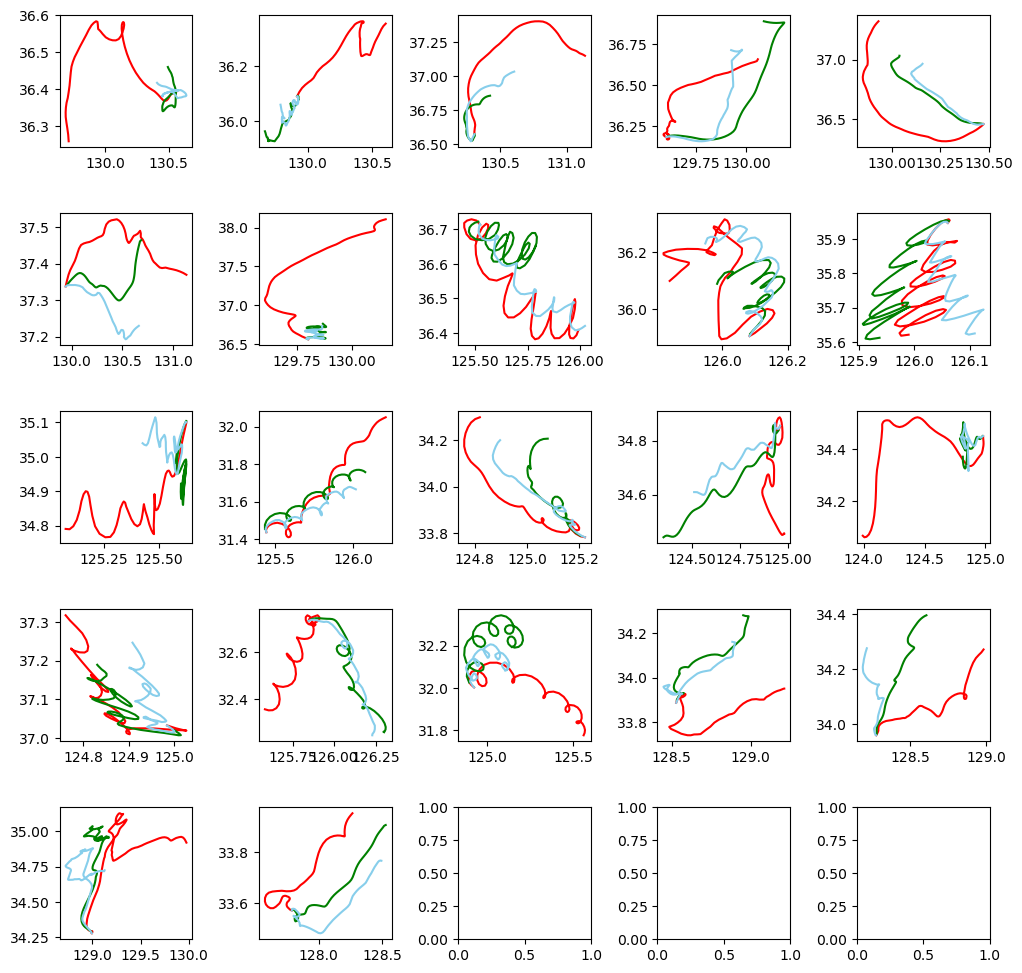

In [22]:
# 30
import lightgbm as lgb 
import random
seed = 42
tf.keras.utils.set_random_seed(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

f, axes = plt.subplots(5, 5)
# 격자 크기 설정
f.set_size_inches((12, 12))
# 격자 여백 설정
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
baseline_MAE_list = list() 
baseline_NCLS_list = list()
MAE_list = list()
NCLS_list = list()
test_case_list = list()

for i in range(len(dataset)):
    # train dataset
    train_X = pd.DataFrame()
    train_y = np.array([[]])
    train = dataset[0:i] + dataset[i+1:len(dataset)]
    
    AE_X = train[0][['wind_x', 'water_velocity_x', 'wind_y', 'water_velocity_y','diff_lon', 'diff_lat']]
    train_X = train[0][['wind_x', 'water_velocity_x', 'wind_y', 'water_velocity_y']]
    train_y = train[0][['diff_lon', 'diff_lat']]
    # 첫 행은 훈련에서 제외
    AE_X = AE_X[1:]
    train_X = train_X[1:]
    train_y = train_y[1:].to_numpy()
    
    for j in range(1,len(train)):
        add = train[j][['wind_x', 'water_velocity_x', 'wind_y', 'water_velocity_y','diff_lon', 'diff_lat']]
        trina_xi = train[j][['wind_x', 'water_velocity_x', 'wind_y', 'water_velocity_y']] 
        trina_yi = train[j][['diff_lon', 'diff_lat']]
        add = add[1:]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        AE_X = pd.concat([AE_X,add],ignore_index = True)
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
        
    # 과거 데이터 훈련데이터에 추가
    for k in range(len(only_train_dataset)):
        add =  only_train_dataset[k][['wind_x', 'water_velocity_x', 'wind_y', 'water_velocity_y','diff_lon', 'diff_lat']]
        trina_xi = only_train_dataset[k][['wind_x', 'water_velocity_x', 'wind_y', 'water_velocity_y']] 
        trina_yi = only_train_dataset[k][['diff_lon', 'diff_lat']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        add = add[1:]
        
        AE_X = pd.concat([AE_X,add],ignore_index = True)
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
    
    # Test dataset
    test = dataset[i]
    start_lon = dataset[i]['start_lon'][0]
    start_lat = dataset[i]['start_lat'][0]
    test_X = test[['wind_x', 'water_velocity_x', 'wind_y', 'water_velocity_y']]
    test_X = test_X[1:]
    test_y = test[['diff_lon', 'diff_lat']]
    test_y = test_y[1:].to_numpy()
    
    
    latent_dim = 4
    AE_X = AE_X.to_numpy()
    autoencoder = Autoencoder(latent_dim)
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.fit(AE_X,AE_X,
                    epochs=100,
                    shuffle=True)
    encoded = autoencoder.encoder(AE_X).numpy()
    decoded = autoencoder.decoder(encoded).numpy()
    add_X = decoded[:,[0,1,2,3]]
    add_y = decoded[:,[4,5]]
    
    train_X = np.concatenate((train_X.to_numpy(),add_X), axis = 0)
    
    train_y = np.concatenate((train_y,add_y), axis = 0)
    
    
    # 행단위로 살펴보기
    test_case_df = dataset[i][['time', 'obs_x1_lon', 'obs_x1_lat', 'wind_y','wind_x','water_velocity_y','water_velocity_x','model_x2_lon', 'model_x2_lat']]
    test_case_df['rf_lon'] = start_lon
    test_case_df['rf_lat'] = start_lat
    test_case_df['ncls_model'] = 0
    test_case_df['ncls_rf'] = 0
    
    # lightgbm 모델 생성
    lightgb_lon = lgb.LGBMRegressor(objective='regression',num_leaves=6,
                              learning_rate=0.009, n_estimators=300,max_depth=5
                              )
    lightgb_lat = lgb.LGBMRegressor(objective='regression',num_leaves=6,
                              learning_rate=0.009, n_estimators=300,max_depth=5
                            )
    
    # lightgbm 모델 훈련
    lightgb_lon.fit(train_X, train_y[:,0])
    lightgb_lat.fit(train_X, train_y[:,1])
    
    # Predict
    y_pred_lon = lightgb_lon.predict(test_X)
    y_pred_lat = lightgb_lat.predict(test_X)
    y_pred_lon = y_pred_lon.reshape((len(y_pred_lon),1))
    y_pred_lat = y_pred_lat.reshape((len(y_pred_lat),1))
    y_pred = np.concatenate((y_pred_lon,y_pred_lat),axis = 1)
    # case 별로 이상행 탐색
    for k in range(1,len(test_case_df)-1):
        test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
        test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
        test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
        test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
    
    test_case_df['rf_diff_lon'] = test_case_df['rf_lon'].diff()
    test_case_df['rf_diff_lon'][0] = 0
    test_case_df['rf_diff_lat'] = test_case_df['rf_lat'].diff()  
    test_case_df['rf_diff_lat'][0] = 0
    test_case_df['model_diff_lon'] = test_case_df['model_x2_lon'].diff() 
    test_case_df['model_diff_lon'][0] = 0
    test_case_df['model_diff_lat'] = test_case_df['model_x2_lat'].diff()
    test_case_df['model_diff_lat'][0] = 0
    test_case_list.append(test_case_df)
    
    # Plot
    lon, lat, baseline_lon, baseline_lat, lon_pred, lat_pred = drift_trajection_show(i,y_pred)
    row = i//5
    col = i%5
    axes[row][col].plot(lon, lat,'r-' ,baseline_lon, baseline_lat, 'g-', lon_pred, lat_pred, 'skyblue')   
    
    # evaluation 
    y = np.concatenate((lon.reshape((lon.shape[0],1)), lat.reshape((lat.shape[0],1))),axis = 1)
    pred = np.concatenate((lon_pred.reshape((lon_pred.shape[0],1)), lat_pred.reshape((lat_pred.shape[0],1))),axis =1)
    baseline_pred = np.concatenate((baseline_lon.reshape((baseline_lon.shape[0],1)), baseline_lat.reshape((baseline_lat.shape[0],1))),axis =1)
    
    #mae
    MAE_list.append(drift_mae(y, pred))
    baseline_MAE_list.append(drift_mae(y, baseline_pred))
    
    #NCLS
    NCLS_list.append(NCLS_score(y, pred))
    baseline_NCLS_list.append(NCLS_score(y, baseline_pred))
    
    for i in range(len(MAE_list)):
        print('------------------------ Model ', i+1, '------------------------')
        print('baseline',str(i),' MAE : ',MAE_list[i])
        print('Model',str(i),' MAE : ', baseline_MAE_list[i])
        print('baseline',str(i),' NCLS : ',baseline_NCLS_list[i])
        print('Model',str(i),' NCLS : ', NCLS_list[i])

plt.show()

In [23]:
# lightgbm # 에포크 처리
mae_sum = 0
baseline_mae_sum = 0
NCLS_sum = 0
baseline_NCLS_sum = 0

for i in range(len(dataset)):
    mae_sum += MAE_list[i]
    baseline_mae_sum += baseline_MAE_list[i]
    NCLS_sum += NCLS_list[i]
    baseline_NCLS_sum += baseline_NCLS_list[i]

# 라이브러리 Mae    
print ('Model Mae : ', mae_sum/len(dataset) )
print ('Baseline Mae : ', baseline_mae_sum/len(dataset) )
print ('Model NCLS : ', NCLS_sum/len(dataset) )
print ('Baseline NCLS : ', baseline_NCLS_sum/len(dataset) )

Model Mae :  0.17655933354926676
Baseline Mae :  0.18057603746811715
Model NCLS :  0.544961778806798
Baseline NCLS :  0.5326670971119444
